# **Législation sécuritaire et criminalité en France**
---

<small>*Par Arthur Bidel, William Olivier et Anh Linh Piketty*</small>

<br>

## Introduction<a class="anchor" id="partie1"></a>

Le thème de l'insécurité, avec celui de l'ordre, occupent une place importante dans le débat public et l'espace politique de ces dernières décennies. Ancrée à droite, la dénonciation d'une justice laxiste accompagne souvent la mise en exergue d'un "sentiment d'insécurité". Ce type de revendication repose sur plusieurs prémisses. Déjà de l'existence des phénomènes dénoncés mais aussi d'un effet à la baisse d'une législation plus stricte sur les phénomènes délinquants. Dans quelle mesure ces postulats s'appuient sur un ancrage empirique concret ? 

Ce projet de programmation s'inscrit dans la continuité de ce débat et tente (modestement) d'identifier l'effet de la production législative sur la criminalité et la délinquance en France. L'objet initial de notre curiosité était de vérifier si un effet à la baisse de la législation sécuritaire sur les taux de criminalité et de délinquance  était en effet constatable. Additionnellement, nous avons cherché à dresser un portrait plus descriptif de l'évolution de ces phénomènes sur les 20 dernières années ainsi que de la législation associée.

Les chiffres répertoriant les nombres de crimes et délit en France sont aujourd'hui disponible sur d'assez large et période et permettent, bien qu'imparfaitement de documenter les différents aspects et évolutions de la criminalité dans l'hexagone. De même, la production législative est rendue disponible au public permettant de constater son évolution quantitativement et qualitativement. Nous approchons les textes de lois sous un angle plutôt quantitatif ici ce qui ne permet pas de mesurer une augmentation de la sévérité des textes par exemple, des approches NLP pourrait être intéressantes à développer pour approfondir cet angle de recherche. 

*NB1 : Les fonctions de visualisation ont été déplacées dans un script python (***visualisation.py***) pour plus de lisibilité*<br>
*NB2 : Le travail de récupération et de mise en forme des données a été assez long pour les deux bases de données (sur les infractions et la législation) et deux autres notebooks leur sont consacrés. Le sommaire cliquable renvoie vers ces notebooks pour chacune des parties correspondantes*

## Sommaire

* [Introduction](#partie1)
* [Installation](#partie2)
* [Récuparation et description des données](#partie3)
    * Base délinquance [(voir le notebook *database_délinquance*)](database_délinquance.ipynb)
    * Base légifrance [(voir le notebook *database_légifrance*)](database_légifrance.ipynb)
* [Analyse exploratoire](#partie4)
    * [Portrait de la délinquance en France](#partie41)
        * [Description et visualisation](#partie411)
        * [Cartographie](#partie412)
    * [La législation sécuritaire en France](#partie42)
        * [Statistiques descriptives](#partie421)
* [Analyse](#partie5)
    * [Choix des indicateurs à régresser](#partie51)
    * [Fusion des bases de données](#partie52)
    * [Régressions de panel](#partie53)
    * [Décalage temporel](#partie54)
* [Conclusion et perspectives](#partie6)
* Annexes [(voir le notebook)](annexes.ipynb)

## Installation<a class="anchor" id="partie2"></a>

In [2]:
!pip install -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 87.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 91.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 87.5 MB/s eta 0:00:00


In [8]:
# Modules
import os, requests, zipfile
import pandas as pd, numpy as np, geopandas as gpd
import s3fs

# Fonctions et styles
from scripts.visualisation import (
    charte_graphique,
    charte_graphique2,
    charte_graphique3,
    dictionnaire_geo,
    all,
    custom_greys_cmap,
    tracer_evolution_taux,
    tracer_evolution_taux_relatif_lisse,
    boxplot_indicateur_par_saison,
    evolution_indicateur_animation,
    animer_evolution_densite,
    evolution_idf_animation,
    get_increase,
    tri_occurrence,
    plot_histogram,
    camembert,
    keywords,
    filter_keyword,
    keywords_occ,
    évolution_indicateur,
    évolution_indicateur,
)

from scripts.regressions import (
    regression,
    Wald_test,
    regression_lags,
)

## Récuparation et description des données<a class="anchor" id="partie3"></a>

Les tableaux de données conçus au début de notre travail, dans les deux notebooks consacrés, ont tous les deux été stockés sur S3 et on les récupère prêts à l'usage dans cette partie. Les parties de récupération et nettoyage des données sont donc optionnelles à la lecture mais offrent néanmoins des éclairages méthodologiques quant à la construction des indicateurs et des variables utilisées dans ce travail (lisez les svp...).

In [2]:
# Information d'accès au cloud MinIO (Bucket de Anh Linh)
fs = s3fs.S3FileSystem(client_kwargs={"endpoint_url": "https://minio.lab.sspcloud.fr"})
MY_BUCKET = "anhlinh"

In [3]:
# Vérification du contenu (on doit retrouver dedans df_indicateurs_dep.csv, df_indicateurs_nat.csv et df_loda.csv)
fs.ls(f"{MY_BUCKET}/diffusion")

['anhlinh/diffusion/.keep',
 'anhlinh/diffusion/df_indicateurs_dep.csv',
 'anhlinh/diffusion/df_indicateurs_nat.csv',
 'anhlinh/diffusion/df_loda.csv']

* #### Tableaux de données concernant la criminalité : 

In [4]:
# Récupération du tableau départemental d'indicateur de criminalité
FILE_PATH_S3_DEP = f"{MY_BUCKET}/diffusion/df_indicateurs_dep.csv"
with fs.open(FILE_PATH_S3_DEP, "rb") as file_in_dep:
    df_indicateurs_dep = pd.read_csv(file_in_dep)

# Vérification
df_indicateurs_dep.head()

,Unnamed: 0,Année,Département,Indicateur,Nombre,Population,Taux (/10 000),Nom Département,Superficie (km2),Densité
0,0,1996,01,Homicides,17.0,499310,0.340470,Ain,5762,86.655675
1,1,1996,02,Homicides,14.0,538017,0.260215,Aisne,7362,73.080277
2,2,1996,03,Homicides,11.0,349376,0.314847,Allier,7340,47.598910
3,3,1996,04,Homicides,6.0,137453,0.436513,Alpes-de-Haute-Provence,6925,19.848809
4,4,1996,05,Homicides,5.0,118526,0.421848,Hautes-Alpes,5549,21.359885


In [5]:
# Récupération du tableau national d'indicateur de criminalité
FILE_PATH_S3_NAT = f"{MY_BUCKET}/diffusion/df_indicateurs_nat.csv"
with fs.open(FILE_PATH_S3_NAT, "rb") as file_in_nat:
    df_indicateurs_nat = pd.read_csv(file_in_nat)

# Vérification
df_indicateurs_nat.head()

,Unnamed: 0,Date,Zone,Indicateur,Nombre,Population,Taux (/10 000),Année,Mois,Saison,Taux relatif,Taux de pauvreté (%)
0,0,1996-01-01,France_Métro,Coups et blessures volontaires,5616.0,57936,0.969345,1996,1,Hiver,1.000000,19.3
1,1,1996-02-01,France_Métro,Coups et blessures volontaires,6115.0,57943,1.055347,1996,2,Hiver,1.088722,19.3
2,2,1996-03-01,France_Métro,Coups et blessures volontaires,6668.0,57951,1.150627,1996,3,Printemps,1.187015,19.3
3,3,1996-04-01,France_Métro,Coups et blessures volontaires,6800.0,57963,1.173162,1996,4,Printemps,1.210262,19.3
4,4,1996-05-01,France_Métro,Coups et blessures volontaires,7415.0,57976,1.278978,1996,5,Printemps,1.319424,19.3


Pour ce qui est de la délinquance, nous disposons de deux tableaux de données, un à l'échelle départementale et un à l'échelle nationale. On trouve dans chacun d'entre eux huit indicateurs de criminalité et de délinquance construit selon la méthodologie actuelle du ministère de l'intérieur. Les huits indicateurs sont les : *homicides*, *tentatives d'homicides*, *coups et blessures volontaires*, *vols avec violence*, *vols sans violence*, *escroqueries*, *violences sexuelles* et *infractions liées à la consommation ou la vente de stupéfiants*.

Nous avons utilisé les nombres brut d'infractions recensées par les forces de l'ordre, par types (107 différents), entre 1996 et 2022, mis à disposition en open data par le ministère de l'intérieur ainsi que les estimations de population de l'INSEE pour obtenir les taux de délinquance (définit comme le rapport du nombre de délit/crime sur la population) associés à chacun des indicateurs.

Nous avons également déjà ajouté à ces bases les variables qui nous serviront de contrôle dans la partie modélisation de ce travail. A savoir la densité pour la base départementale et le taux de pauvreté pour la base nationale. La densité sert ici de proxy à la densité urbaine qui pourrait à la fois être un facteur criminogène et un handicap pour le maintien de l'ordre. Elle a été déterminée grâce aux estimations de population déjà mentionnées et aux superficie des départements scrapées de Wikipédia. Le taux de pauvreté a été obtenue via l'INSEE mais malheureusement nous n'avons pas trouvé de données à l'échelle départementale pour toutes les années couvertes par nos bases.

La plupart de nos sources comportaient des données manquantes pour les territoires d'Outre-Mer et nous avons donc décidé de centrer notre travail sur la France métropolitaine. De même il n'était pas possible d'obtenir des données à granularité mensuelle pour les données départementales et on s'est donc satisfait d'une granularité annuelle. 

Vous pouvez trouvez plus de précision sur la construction de ces tables dans le notebook consacré ([juste là !](database_délinquance.ipynb)).

* #### Tableaux de données concernant la production législative : 

In [6]:
# Récupération de la base de données législative
FILE_PATH_S3_LODA = f"{MY_BUCKET}/diffusion/df_loda.csv"
with fs.open(FILE_PATH_S3_LODA, "rb") as file_in_loda:
    df_loda = pd.read_csv(file_in_loda)

# Vérification
df_loda.head()

,Unnamed: 0,Titre,ID,Date,Nature,Etat,Origine,Date Publication,Année,Mois
0,0,Arrêté du 31 décembre 2008 relatif aux modalit...,LEGITEXT000020083722_27-05-2024,2008-12-31,ARRETE,VIGUEUR,LEGI,2009-01-01T00:00:00.000+0000,2009,1
1,1,Arrêté du 31 décembre 2008 portant création d'...,LEGITEXT000020167092_30-01-2009,2008-12-31,ARRETE,VIGUEUR,LEGI,2009-01-29T00:00:00.000+0000,2009,1
2,2,Décret n° 2008-1549 du 31 décembre 2008 portan...,LEGITEXT000020080924_02-01-2009,2008-12-31,DECRET,VIGUEUR,LEGI,2009-01-01T00:00:00.000+0000,2009,1
3,3,Arrêté du 31 décembre 2008 relatif aux modalit...,LEGITEXT000020083722_18-12-2015,2008-12-31,ARRETE,VIGUEUR,LEGI,2009-01-01T00:00:00.000+0000,2009,1
4,4,Arrêté du 31 décembre 2008 relatif aux modalit...,LEGITEXT000049943833_01-10-2024,2008-12-31,ARRETE,VIGUEUR,LEGI,2009-01-01T00:00:00.000+0000,2009,1


En ce qui concerne la production législative, notre DataFrame principal recense le nombre de textes publiés chaque mois, classés par type (Lois, Arrêtés, Ordonnances, Décrets et Décisions) de 2006 à 2022. Ces données proviennent du fonds LODA via l'API délivrée par Légifrance. 

Cependant, les données ne sont pas exhaustives (et par conséquent non représentatives de l’ensemble de l’activité législative) puisqu'elles ne reflètent pas les modifications législatives plus subtiles, telles que l’alourdissement des peines, la modification d’articles existants ou l’ajout de précisions juridiques (requalification d’une infraction mineure en délit par exemple) qui peuvent avoir un impact significatif sans pour autant générer de nouveaux textes.

Ces données offrent, néanmoins, un aperçu des thématiques traitées depuis 2006, mettant en évidence la fréquence de publication des textes législatifs. Cette base de données nous donnent accès au nombre d’occurrences de chaque catégorie de texte sans refléter leur portée ou leur impact réel. Par exemple, une loi largement débattue apparaît de la même manière qu’un arrêté technique de moindre envergure.

Cette absence de mesure du degré d’importance ou des modifications souligne les limites de cette étude : l'analyse reste quantitative et des approches en NLP pourrait enrichir la démarche en permettant d'évaluer la sévérité des textes adoptés par exemple. 

De même vous pouvez, pour plus de détails, consulter le notebook consacré ([ici](database_légifrance.ipynb)).

## Analyse exploratoire<a class="anchor" id="partie4"></a>

### Portrait de la délinquance en France<a class="anchor" id="partie41"></a>

#### Description et visualisation<a class="anchor" id="partie411"></a>

Etudions d'abord l'évolution de chacun de nos indicateurs sur la période de données disponible (1996 à 2022).

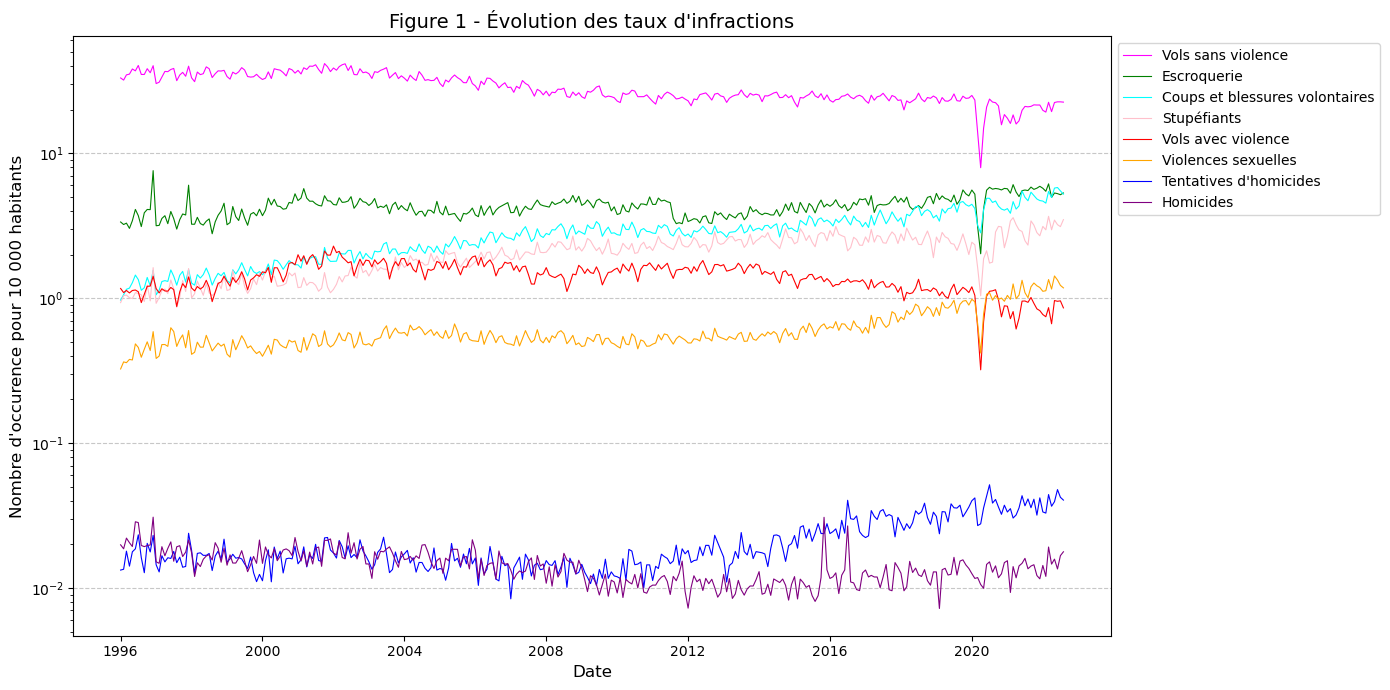

In [9]:
tracer_evolution_taux(df_indicateurs_nat, charte_graphique, taux = "Taux (/10 000)", use_log_scale = True, title="Figure 1 - Évolution des taux d'infractions")

Même si l'échelle logarithmique écrase un peu les évolutions de long terme, la Figure 1 permet d'illustrer les évolutions des nombres d'infractions pour 10 000 habitants pour chacun de nos indicateurs. On remarque d'ores et déjà des évolutions contrastées. Certains types d'infractions sont plutôt à la baisse (homicides, vols de tout types) quand d'autres augmentent (tentatives d'homicides, coups et blessures volontaires, escroqueries).

De manière générale, les taux d’infraction ne présentent pas de variations brutales au fil du temps : ils suivent une tendance relativement stable à part les homicides et les tentatives d'homicides qui repartent à la hausse depuis la dernières décennies (même si les homicides sont toujours moins fréquents en 2022 qu'en 1996).

En normalisant tous les taux à leur valeur en 1996, les Figures 2 et 3 permettent de visualiser l’évolution relative de chaque type d’infraction par rapport à cette année de référence. En particulier, la Figure 3 présente les courbes lissée des tendances grâce à l’application d’un filtre de Savitzky-Golay. Ce filtre est conçu pour lisser les séries temporelles en ajustant des polynômes locaux à travers une fenêtre glissante, ce qui permet d'éliminer le "bruit" statistique.

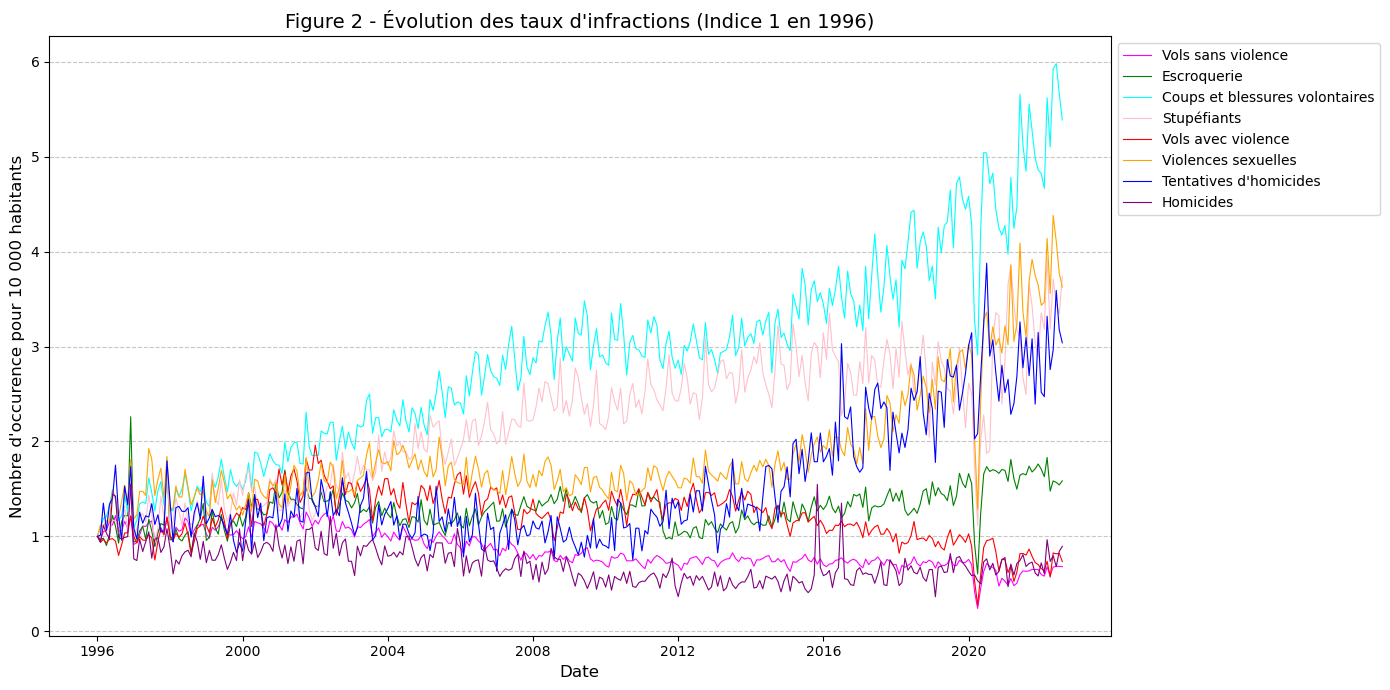

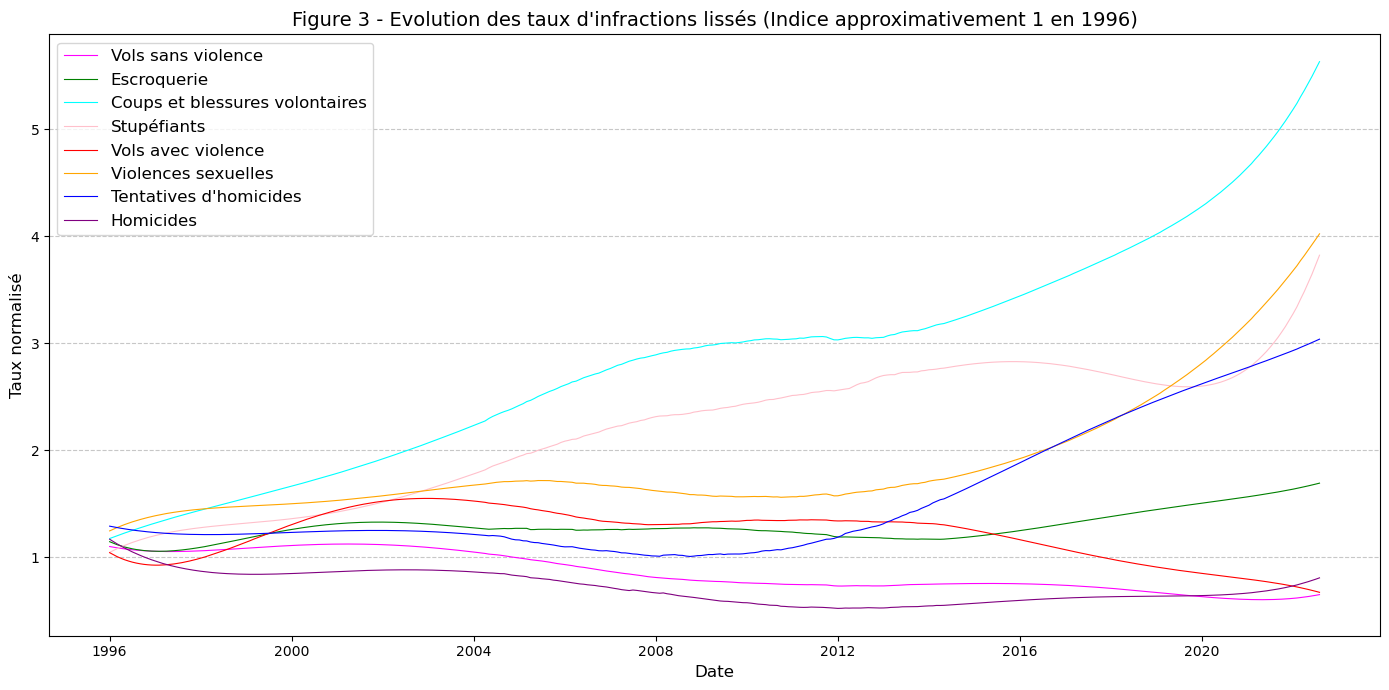

 Homicides entre 1996-01-01 et 2022-08-01: -10.47858905472778 %
 Tentatives d'homicides entre 1996-01-01 et 2022-08-01: 203.96935961992378 %
 Vols avec violence entre 1996-01-01 et 2022-08-01: -26.53294218387946 %
 Vols sans violence entre 1996-01-01 et 2022-08-01: -31.904976615785706 %
 Escroquerie entre 1996-01-01 et 2022-08-01: 58.49635036177963 %
 Coups et blessures volontaires entre 1996-01-01 et 2022-08-01: 438.69498681855345 %
 Violences sexuelles entre 1996-01-01 et 2022-08-01: 262.6825902105622 %
 Stupéfiants entre 1996-01-01 et 2022-08-01: 273.78697439863026 %


In [10]:
tracer_evolution_taux(df_indicateurs_nat, charte_graphique, taux = "Taux relatif", title="Figure 2 - Évolution des taux d'infractions (Indice 1 en 1996)")
tracer_evolution_taux_relatif_lisse(df_indicateurs_nat, charte_graphique, title="Figure 3 - Evolution des taux d'infractions lissés (Indice approximativement 1 en 1996)")

liste = ['Homicides', "Tentatives d'homicides", 'Vols avec violence', 'Vols sans violence', 'Escroquerie', 'Coups et blessures volontaires', 'Violences sexuelles', 'Stupéfiants']
for indicateur in liste : 
    get_increase(df_indicateurs_nat, indicateur=indicateur, date1='1996-01-01', date2='2022-08-01')

In [11]:
get_increase(df_indicateurs_nat, indicateur='Violences sexuelles', date1='1996-01-01', date2='2007-01-01')
get_increase(df_indicateurs_nat, indicateur='Violences sexuelles', date1='2007-01-01', date2='2022-08-01')

 Violences sexuelles entre 1996-01-01 et 2007-01-01: 48.36255085018586 %
 Violences sexuelles entre 2007-01-01 et 2022-08-01: 144.45696581261487 %


A nouveau, on constate des tendances contrastées ce qui traduit une transformation des phénomènes délinquants. Les menages seraient moins souvent confrontés à des vols de tout types mais plus souvent à des escroqueries ce qui coincide avec les enquêtes de victimation. Plus généralement, les homicides et vols sont à la baisse alors que le reste des indicateurs augmentent (plus ou moins). On constate par exemple que les coups et blessures volontaires ont plus que quadruplées (augmentation de 438%). Les violences sexuelles augmentent elles-aussi significativement sur la période puisqu'elles font plus que doubler. Dans un contexte de libération de la parole et d’incitation à déposer plainte, notamment à travers l’amélioration (toute relative) des conditions d’accueil des victimes, les personnes déclarent plus fréquemment avoir subi des violences sexuelles et déposent plus souvent plainte. Cette augmentation ne concorde en revanche pas avec les résultats des enquêtes de victimation qui restent plutôt stable. Il est par ailleurs intéressant de constater que l'augmentation des violences sexuelles déclarées est beaucoup plus accrue dans la deuxième moitié de la période (qui correspond à la période d'existence du mouvement Me Too).

Enfin, la Figure 4, quant à elle, zoome sur une période spécifique : celle de la pandémie de COVID-19.

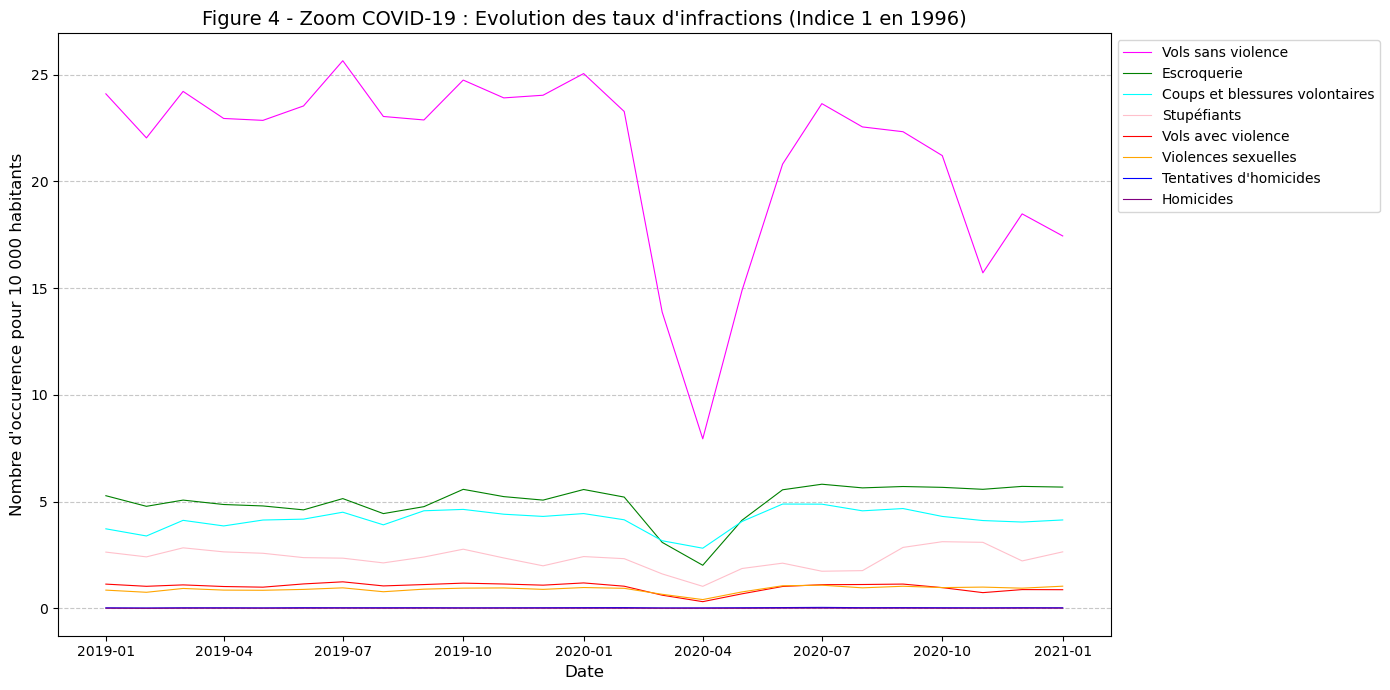

In [12]:
tracer_evolution_taux(df_indicateurs_nat, charte_graphique, title="Figure 4 - Zoom COVID-19 : Evolution des taux d'infractions (Indice 1 en 1996)", use_log_scale=False, time_period=["2019-01-01", "2021-01-01"])

Cette période est marquée par une chute significative de presque tous les indicateurs, avec un creux particulièrement notable en avril 2020, correspondant aux mesures de confinement les plus strictes. Seuls les homicides semblent relativement épargnées par cette baisse, ce qui pourrait s'expliquer par la nature moins opportuniste de ce type de crime (donc moins influencé par les restrictions de mobilité). L'activité criminelle a ainsi été largement perturbée par les restrictions de déplacement, la fermeture des commerces, l'augmentation de la surveillance, etc.

D'autres tendance globale de l'activité criminelle se remarques dans nos données, notamment une certaine saisonnalité.

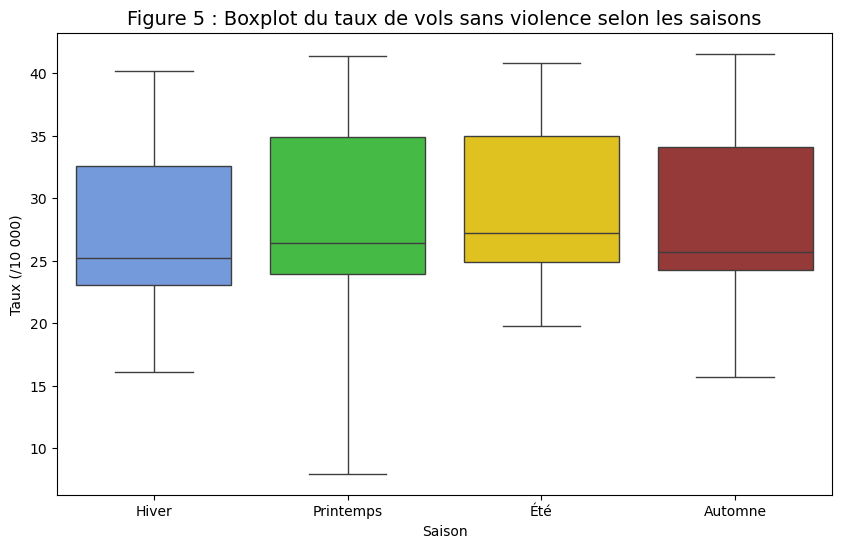

In [13]:
boxplot_indicateur_par_saison(df_indicateurs_nat, "Vols sans violence", title="Figure 5 : Boxplot du taux de vols sans violence selon les saisons")

La Figure 6 n'illustre que le cas des vols sans violences, mais en affichant les autres boxplot, une tendance générale à un taux d'infractions plus élevé en été apparaît pour tous les indicateurs.

#### Cartographie<a class="anchor" id="partie412"></a>

Pour finir, nous une représentation plus visuelle de ces évolutions avec des cartes animées. Il est intéressant de constater que si, pour certains indicateurs certaines concentrations géographiques restent constantes autour du temps (autour de l'Ile de France et de la côté d'Azur souvent), ces phénomène de concentratons n'existent pas pour les homicides ou les violences sexuelles qui semblent beaucoup plus uniformément répartis sur le territoire.

*NB3 : On s'est rendu compte que les animations ne s'affichaient pas dans le notebook sur GitHub, elles sont donc sauvegardées dans le dossier ***animations*** pour être visualisée au besoin.*

In [ ]:
for indicateur in liste :
    evolution_indicateur_animation(df_indicateurs_dep, indicateur)   

En parallèle de ces évolutions assez substantielles de nos indicateurs de criminalité, on a cherché à observer si la densité évoluait particulièrement sur la période. En pratique l'échelle du département est probablement trop large pour rendre compte de ces évolutions (les campagnes "noient" les évolutions qui sont surtout urbaines). Concrètement, la carte animée est plutôt très statique: étant donné que l'échelle est adaptée à la densité minimale et maximale des départements, la densité exceptionnellement élevée de Paris tend à écraser les variations observées dans les autres départements.

Plus généralement, en consultant la littérature associée, il semble que l'inclusion de critère géographique dans l'étude de la criminalité pose souvent ce type de problème puisque l'échelle départementale est souvent inadaptée à l'échelle à laquelle ont étudie souvent les organisations spatiales.

In [14]:
animer_evolution_densite(df=df_indicateurs_dep, colonne_densite='Densité')

KeyboardInterrupt: 

Si on est très attentif, on voit que l'essentiel des variations se fait au niveau de l'Ile de France, on a donc proposé un zoom au niveau de cette zone géographique, qui résume en pratique quasi la totalité des variations de densité visible à cette échelle.

In [ ]:
evolution_idf_animation(df_indicateurs_dep, 'Densité')

### La législation sécuritaire en France<a class="anchor" id="partie42"></a>

#### Statistiques descriptives<a class="anchor" id="partie421"></a>

On cherche, pour cette base de données, à observer les différents types de textes promulgués et leur part respective. Cette analyse est présentée d'abord pour l'ensemble des années (Figure 6), puis décomposée au fil du temps (figures suivantes), permettant ainsi de suivre l'évolution des publications.

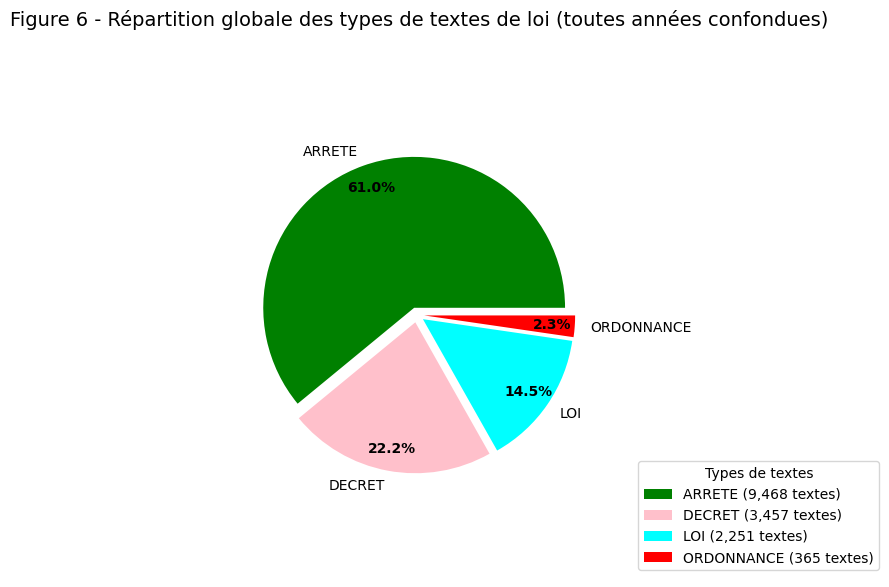

In [16]:
camembert(df_loda)

La base de données obtenue via l'API est à l'état brute, c'est-à-dire que chaque ligne correspond à une observation : chaque ligne représente, en effet, un texte individuel avec les informations sur sa publication.

Afin de produire une visualisation temporelle de ces données, nous avons réorganiser ces données pour obtenir un tableau agrégé qui montre, pour chaque mois, chaque année et chaque type de texte, le nombre de ce type texte de loi promulgués en fonction de sa nature (loi, décret, arrêté, ordonnance). C'est le rôle de la fonction tri_occurrence, en agrégeant les observations par mois et par nature. 

La ligne de code ci-dessous permet de mieux comprendre l'idée générale du tableau obtenu grâce à la fonction tri_occurrence appliquée au dataframe df_loda initial.

In [17]:
tri_occurrence(df_loda).head(10)

,year,month,day,Date,Indicateur,Nombre,Cumulatif
0,1996,1,1,1996-01-01,Texte,1.0,1.0
1,1996,1,1,1996-01-01,Arrete,1.0,1.0
2,1996,1,1,1996-01-01,Ordonnance,0.0,0.0
3,1996,1,1,1996-01-01,Loi,0.0,0.0
4,1996,1,1,1996-01-01,Decret,0.0,0.0
5,1996,2,1,1996-02-01,Ordonnance,0.0,0.0
6,1996,2,1,1996-02-01,Arrete,3.0,4.0
7,1996,2,1,1996-02-01,Loi,1.0,1.0
8,1996,2,1,1996-02-01,Texte,9.0,10.0
9,1996,2,1,1996-02-01,Decret,5.0,5.0


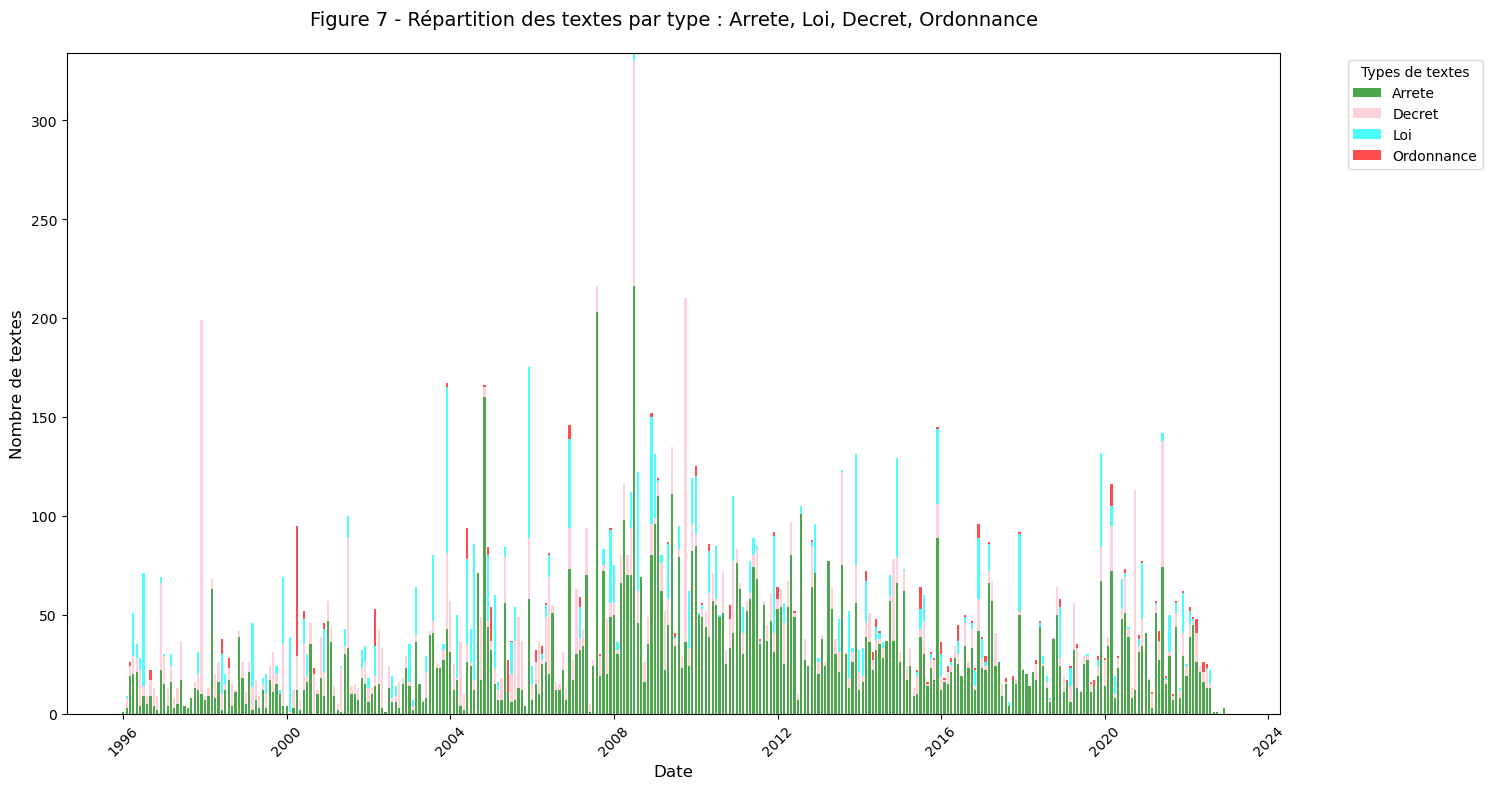

In [10]:
all = ["Arrete", "Loi", "Decret", "Ordonnance"]

plot_histogram(tri_occurrence(df_loda), all, numero_figure ='Figure 7 - ')

Ce diagramme en barre montre le nombre de textes législatifs publiés de 1996 à 2022. Globalement, on observe une tendance progressive à la hausse de 1996 à 2009 du nombre de publications au cours du temps, jusqu'à atteindre un pic de plus de 300 textes en 2009, puis une légère tendance à la baisse jusqu'en 2020. Les arrêtés (barres vertes) sont la première catégorie la plus fréquente et constituent la majeure partie de l'activité législative, en particulier à partir de 2006. Les lois (bleu clair), décrets (rose pâle) et ordonnances (rouge) sont moins nombreux, mais réguliers et leur volume reste significatif pour l'analyse. Les ordonnances (rouge) sont bien plus rares pendant toute la période étudiée.

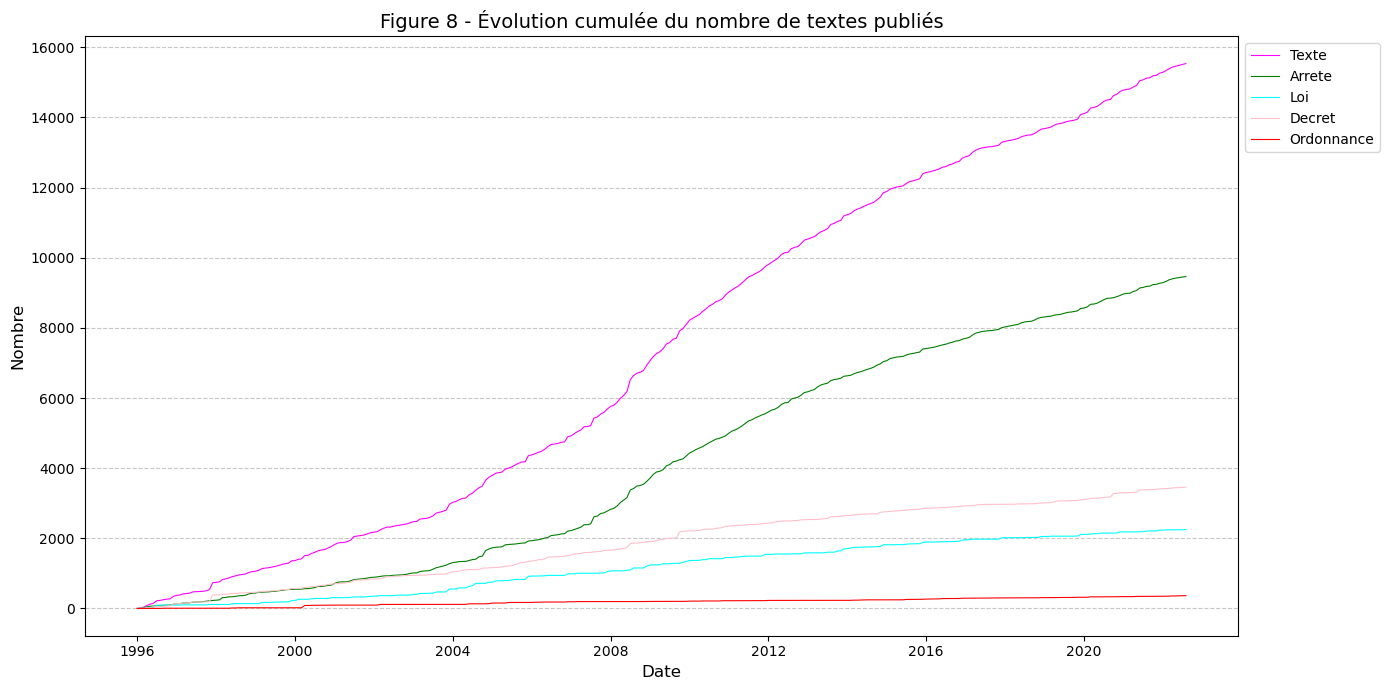

In [19]:
tracer_evolution_taux(tri_occurrence(df_loda), charte_graphique3, taux = "Cumulatif", title="Figure 8 - Évolution cumulée du nombre de textes publiés", xlabel = "Date",ylabel = "Nombre", time_period = ["1996-01-01", "2022-08-31"])

Cette figure présente l’évolution cumulée des textes publiés au fil du temps et donc permet de visualiser plus clairement la croissance globale de la production législative depuis 1996. La courbe rose (Texte) illustre bien la tendance précédemment mentionnée plutôt décroissante depuis 2009 avec une courbe d'abord linéaire voire concave et convexe ensuite. Elle atteint plus de 15 000 textes en 2022 dont les arrêtés (vert) constituent presque 10 000 publications. Les lois, décrets et ordonnances s’accumulent plus lentement, avec une progression presque linéaire.

## Analyse<a class="anchor" id="partie5"></a>

On essaye de déterminer l'effet de la production législative sur les nombre de délits avec une modélisation économétrique assez classique, à savoir une régression. On a fait le choix d'une régression de panel qui inclue les observations sur plusieurs individus (départements) recueillies au fil du temps (années) bien que nous n'ayons pas pu récupéré certaines données au niveau départemental. Il est en effet toujours possible de mettre en place la régression même si certaine covariables ne varient qu'en fonction du temps. La régression de panel nous permet donc d'évaluer un effet national (égal entre tous les départements) pour les variables indicées seulement par le temps ainsi que des effets spécifiques au département. Nous avons fait ce choix pour plusieurs raisons, d'une part par curiosité, mais aussi pour augmenter la robustesse statistique du modèle avec un plus grand nombre d'observations (elles sont ici multipliées par le nombre de département). 

$$
Y_{it} = \alpha + \beta \cdot L_t + \gamma \cdot P_t + \delta \cdot D_{it}+ \mu _i + \epsilon _{it}
$$

où : <br>
$Y_{it}$ : Nombre d'occurrence pour 10 000 habitants de l'indicateur de criminalité choisi du département i à l'année t<br>
$L_t$ : Mesure de l'intensité législative par le nombre de texte publié en une année. Comme nous n'avons pas les arrêtés préfectoraux sur légifrance nous sommes contraints d'en faire une variable constante pour tous les départements i, elle est donc seulement indicée par t (les différences entre département viennent donc des variables de contrôles a priori)<br>
$P_t$: Taux de pauvreté annuelle et au niveau nationale, car là nous n'avons accès qu'aux données nationales <br>
$D_{it}$ : Densité et la population pour chaque département i et chaque année t<br>
$\mu _i$ : Effet fixe aux départements (pour différences structurelles non observées)<br>
$\epsilon _{it}$ : Terme d'erreur<br>

Une partie de notre réflexion dans cette partie porte sur l'inclusion ou non des effets fixes par département $\mu_i$.


### Choix des indicateurs à régresser <a class="anchor" id="partie51"></a>

Nous avons choisi d'effectuer nos régressions sur seulement certains de nos indicateurs de criminalité. Nous avons essayez d'en choisir deux avec des évolutions différentes depuis 1996, des nombres recensés assez important et qui revenait assez souvent dans les titres de textes de lois. Lorsque nous avons utilisé l'API Légifrance nous avons filtré sur le contenu des textes ce qui nous donne une base de données qui contient des textes mentionnent certaines infractions dans leur corps sans les viser directement dans le titre. On se concentre ici sur les textes qui mentionnent dès le titre les indicateurs qui nous intéressent.

In [9]:
keywords_occ(df_loda, keywords)

{'délinquance': 35,
 'crime': 49,
 'délit': 8,
 'Homicide': 0,
 'Vol': 231,
 'Stupéfiant': 158,
 'Escroquerie': 3,
 'Contrefaçon': 8,
 'Sequestration': 0,
 'Recel': 0,
 'Proxénétisme': 1,
 'Menace': 63,
 'Cambriolage': 0,
 'infraction': 218,
 'Attentat': 4,
 'dégradation': 18,
 'Outrage': 1}

Ainsi, on choisit les indicateurs *Vols sans violence* et *Stupéfiants* car ce champ lexical revient assez souvent dans les titres de textes pour qu'on ait suffisamment d'observations non nulles. On veut éviter qu'on ait trop d'année où zéro texte sont publiés sur ces sujets.

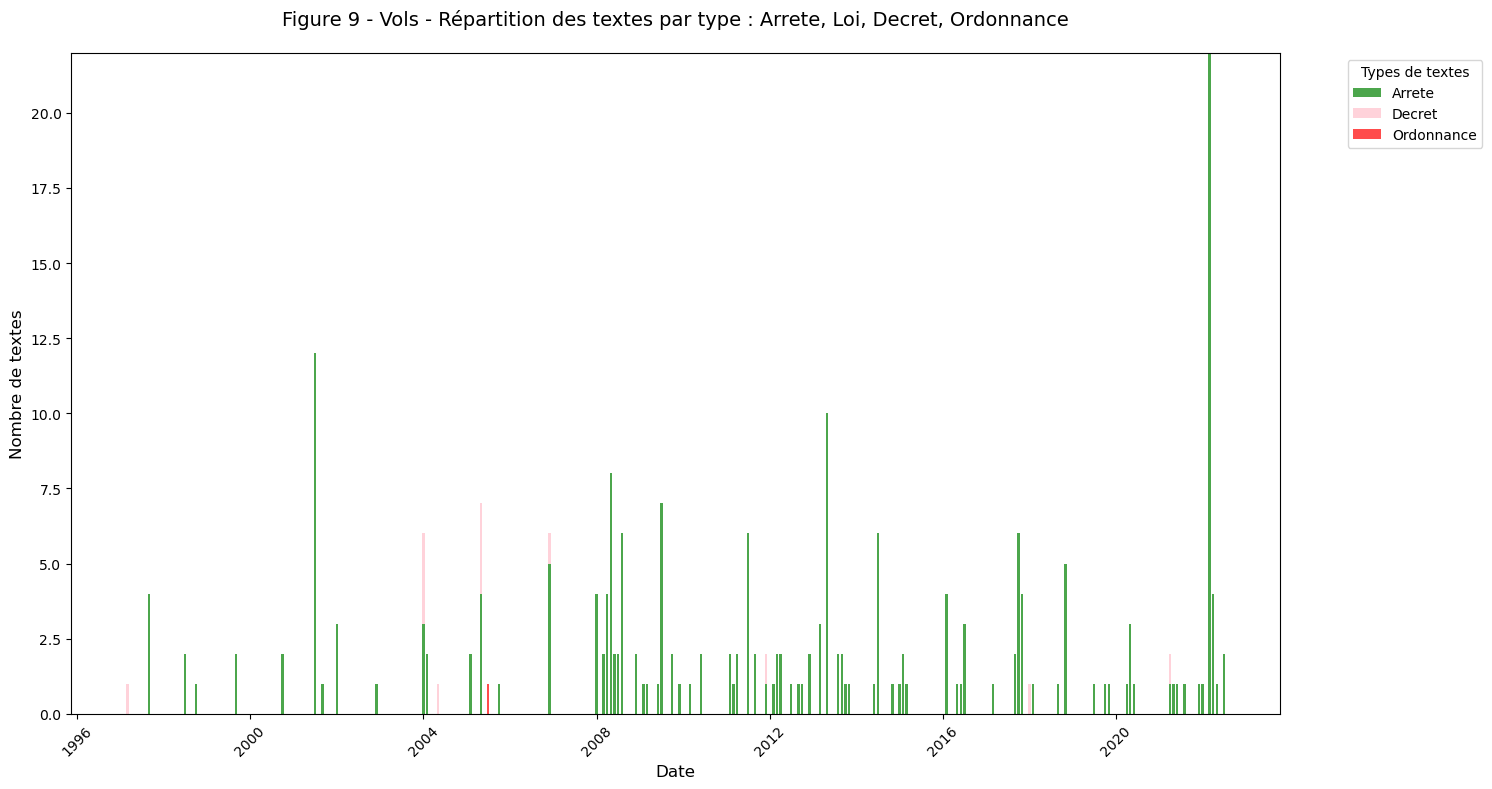

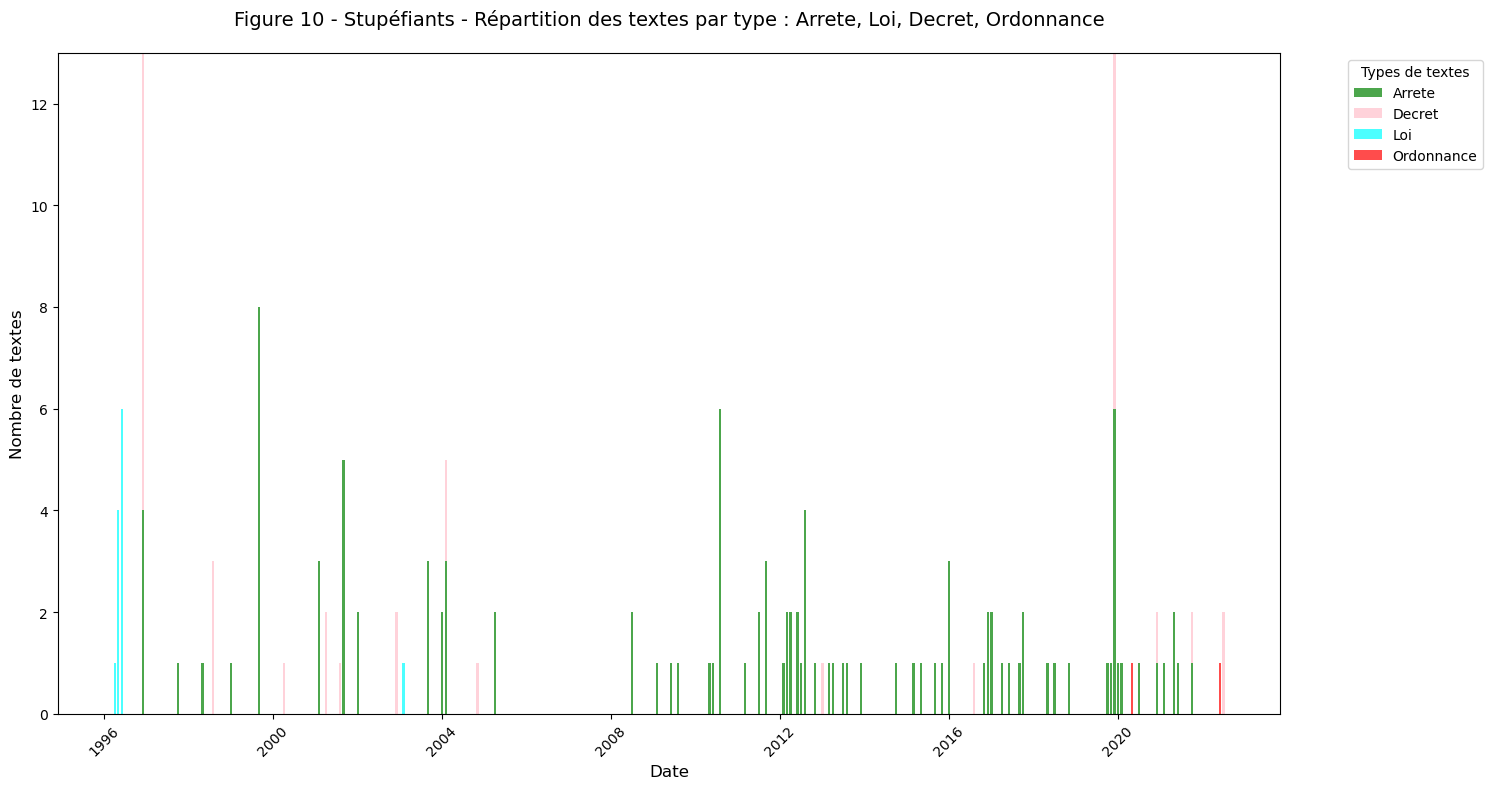

In [13]:
plot_histogram(tri_occurrence(filter_keyword(df_loda, r"\bvols?\b")), all,numero_figure ='Figure 9 - Vols - ')
plot_histogram(tri_occurrence(filter_keyword(df_loda, r"\bstupéfiants?\b")), all,numero_figure ='Figure 10 - Stupéfiants - ')

Pour les deux indicateurs, on remarque à partir de 2008 une augmentation de la fréquence de publication de textes les ciblant. On rappelle en revanche qu'on avait observé une baisse des vols (à la fois sans violence et avec violence) mais une hausse des infractions liées aux stupéfiants entre 1996 et 2008.

### Fusion des bases de données<a class="anchor" id="partie52"></a>

Pour mettre en place nos régressions, on merge nos différentes bases de données et on ne conserve que la variable à régresser et les régresseurs que nous avons choisi. On mets les colonnes de département et d'année en index. On utilise la fonction ci-dessous pour mettre en forme nos données. Pour effectuer le reste des analyses, on utilisera les fonctions du script ***regressions.py***.

In [9]:
def mise_en_forme_reg(keyword, indicateur):
    '''
    Prépare un DataFrame structuré pour effectuer une analyse de régression.

    Args:
    keyword (str): Mot-clé utilisé pour filtrer les articles dans le DataFrame `df_loda`.
    indicateur (str): Nom de l'indicateur de criminalité choisi.
    
    Returns: Un DataFrame contenant les données fusionnées et prêtes pour une analyse de régression.
    '''
    # Préparation de LODA
    df_loda_reg = df_loda.drop([ "Unnamed: 0", "ID", "Date", "Nature", "Etat", "Origine", "Date Publication", "Mois"], axis = 1)
    df_loda_filtre = filter_keyword(df_loda_reg,fr"\b{keyword}s?\b")
    df_loda_reg_filtre = df_loda_filtre.groupby("Année").size().reset_index(name="Nombre d'articles")
    
    # Préparation du taux de pauvreté 
    df_indicateurs_nat.head()
    df_indicateurs_nat_reg = df_indicateurs_nat.loc[: ,["Année", "Taux de pauvreté (%)"]]
    df_pauvrete_percent = df_indicateurs_nat_reg.drop_duplicates()

    # Préparation des autres régresseurs et filtrage sur l'indicateur de criminalité choisi
    df_indicateurs_reg = df_indicateurs_dep.drop([ "Unnamed: 0", "Superficie (km2)", "Nombre" , "Département"], axis = 1)
    df_indicateurs_reg = df_indicateurs_reg[df_indicateurs_reg["Indicateur"] == indicateur]

    df_pauvrete_loda_nbr= pd.merge(df_pauvrete_percent, df_loda_reg_filtre, on="Année", how="outer")
    df_reg =pd.merge(df_pauvrete_loda_nbr, df_indicateurs_reg, on = "Année", how = "outer")

    df_reg["Nombre d'articles"] = df_reg["Nombre d'articles"].fillna(0) # On remplace les valeurs manquante par 0
    df_reg = df_reg.drop(["Indicateur"], axis = 1) # On se débarasse de la colonne 'Indicateur' sur laquelle on ne régresse pas
    df_reg = df_reg.set_index(['Nom Département', 'Année']) # On met en index les colonnes qui indices nos variables

    return(df_reg)

In [10]:
# Visualisation du DataFrame de régression pour 'Vols sans violence'
mise_en_forme_reg('vol', 'Vols sans violence')

,,Taux de pauvreté (%),Nombre d'articles,Population,Taux (/10 000),Densité
Nom Département,Année,,,,,
Ain,1996,19.3,0.0,499310,242.494643,86.655675
Aisne,1996,19.3,0.0,538017,319.878368,73.080277
Allier,1996,19.3,0.0,349376,280.099377,47.598910
Alpes-de-Haute-Provence,1996,19.3,0.0,137453,353.066139,19.848809
Hautes-Alpes,1996,19.3,0.0,118526,321.954677,21.359885
...,...,...,...,...,...,...
Essonne,2022,19.3,30.0,1319836,172.347170,731.616408
Hauts-de-Seine,2022,19.3,30.0,1641277,236.248970,9325.437500
Seine-Saint-Denis,2022,19.3,30.0,1679240,255.401253,7115.423729


In [11]:
# Visualisation du DataFrame de régression pour 'Stupéfiant'
mise_en_forme_reg('stupéfiant', 'Stupéfiants')


,,Taux de pauvreté (%),Nombre d'articles,Population,Taux (/10 000),Densité
Nom Département,Année,,,,,
Ain,1996,19.3,24.0,499310,11.816307,86.655675
Aisne,1996,19.3,24.0,538017,10.427180,73.080277
Allier,1996,19.3,24.0,349376,7.813931,47.598910
Alpes-de-Haute-Provence,1996,19.3,24.0,137453,24.590224,19.848809
Hautes-Alpes,1996,19.3,24.0,118526,21.598637,21.359885
...,...,...,...,...,...,...
Essonne,2022,19.3,3.0,1319836,26.086574,731.616408
Hauts-de-Seine,2022,19.3,3.0,1641277,30.031494,9325.437500
Seine-Saint-Denis,2022,19.3,3.0,1679240,53.000167,7115.423729


### Régressions de panel<a class="anchor" id="partie53"></a>

Les effets fixes départementaux capturent des différences structurelles non observées. On se demande ici s'ils doivent être inclus dans notre régression de panel. Intuitivement, on pourrait faire l'hypothèse de différences de facilité d'application des lois ou du travail des forces de l'ordre selon le département. 

Pour nos deux indicateurs, on va donc faire une régression sans et avec effets fixes et ensuite effectuer un test de Wald sur les résultats pour savoir si on conserve ou non les effets fixes dans nos essais de régressions incluant des décalages temporels.

**EXPLIQUER TEST DE WALD**

On commence par le cas des *Vols dans violence*.

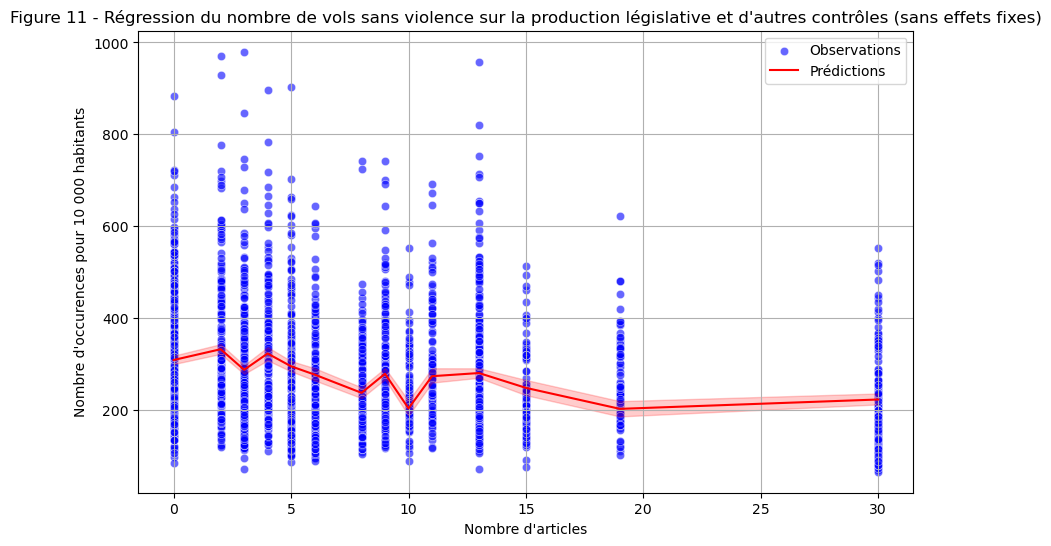

{'results':                           PanelOLS Estimation Summary                           
 Dep. Variable:         Taux (/10 000)   R-squared:                        0.5256
 Estimator:                   PanelOLS   R-squared (Between):              0.6174
 No. Observations:                2592   R-squared (Within):               0.3357
 Date:                Sun, Dec 29 2024   R-squared (Overall):              0.5256
 Time:                        19:32:48   Log-likelihood                -1.531e+04
 Cov. Estimator:            Unadjusted                                           
                                         F-statistic:                      716.50
 Entities:                          96   P-value                           0.0000
 Avg Obs:                       27.000   Distribution:                  F(4,2587)
 Min Obs:                       27.000                                           
 Max Obs:                       27.000   F-statistic (robust):             716.50
     

In [26]:
# Régressions sans effets fixes vols sans violence
reg_vol_sans_effet = regression(mise_en_forme_reg('vol', 'Vols sans violence'), title="Figure 11 - Régression du nombre de vols sans violence sur la production législative et d'autres contrôles (sans effets fixes)")
reg_vol_sans_effet


Effets fixes par département:
                          estimated_effects
Nom Département                           
Ain                            -101.826746
Aisne                          -129.744210
Allier                         -344.676591
Alpes-de-Haute-Provence        -431.664641
Hautes-Alpes                   -481.738690
...                                    ...
Essonne                         561.347087
Hauts-de-Seine                 1059.829477
Seine-Saint-Denis              1089.411293
Val-de-Marne                    812.603566
Val-d'Oise                      614.639002

[2592 rows x 1 columns]


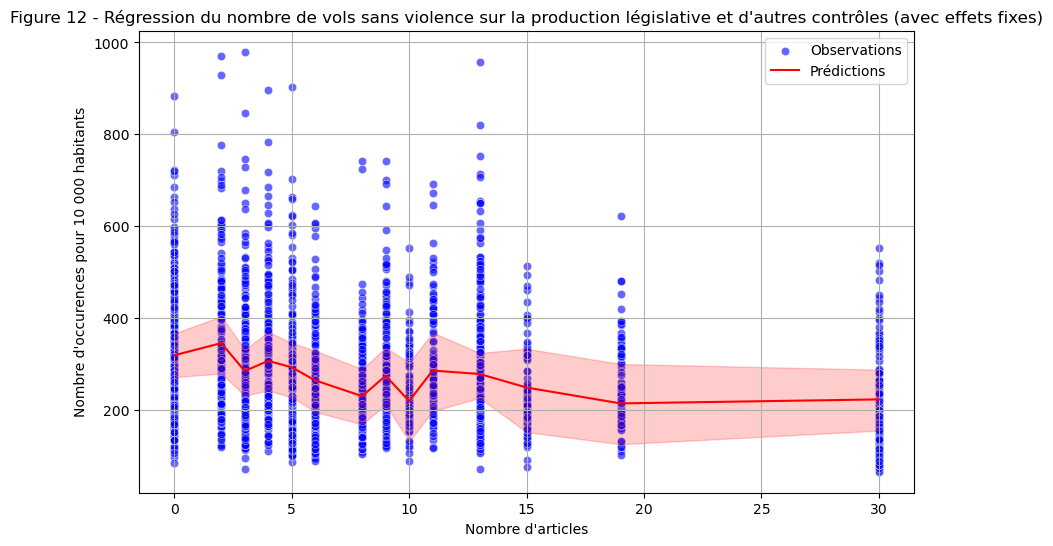

{'results':                           PanelOLS Estimation Summary                           
 Dep. Variable:         Taux (/10 000)   R-squared:                        0.5961
 Estimator:                   PanelOLS   R-squared (Between):             -23.703
 No. Observations:                2592   R-squared (Within):               0.5961
 Date:                Sun, Dec 29 2024   R-squared (Overall):             -15.781
 Time:                        19:32:48   Log-likelihood                -1.365e+04
 Cov. Estimator:            Unadjusted                                           
                                         F-statistic:                      919.45
 Entities:                          96   P-value                           0.0000
 Avg Obs:                       27.000   Distribution:                  F(4,2492)
 Min Obs:                       27.000                                           
 Max Obs:                       27.000   F-statistic (robust):             919.45
     

In [27]:
# Régressions avec effets fixes vols sans violence
reg_vol_avec_effet = regression(mise_en_forme_reg('vol', 'Vols sans violence'), entity_effects=True, title="Figure 12 - Régression du nombre de vols sans violence sur la production législative et d'autres contrôles (avec effets fixes)")
reg_vol_avec_effet

In [28]:
# Test de Wald : Vols sans violence
Wald_test(reg_vol_avec_effet, reg_vol_avec_effet)

Wald Test Statistic: 0.0
Degrees of Freedom: 95
P-value: 1.0


"Pas d'évidence pour préférer FEM. Utilisez le modèle pooled OLS."

Ici la régression sans effets fixes est préférable, on se contente donc de commenter celle-là. 

Cette première régression de panel permet d'une part de voir une significance statistique très forte pour tout nos régresseurs, car les p-values associées sont toutes sous les 0.01 conventionnel, mais un effet négatif faible  de ces derniers sur la variable expliquée, à part pour le taux de pauvreté pour lequel l'effet est plus conséquent. Une augmentation de 1% du taux de pauvreté se traduirait dans la variable prédite par une variation d'environ -44, ceteris paribus, ce qui n'est pas négligeable pour des niveau d'occurrences pour 10 000 habitants autour de 200 à 300. La littérature sur le sujet suggère cependant de faire attention lorsqu'on fait de la pauvreté une cause du crime.

Pour ce qui est de notre variable d'intérêt, le nombre de texte publié, si l'effet est statistiquement significatif, on peut s'interroger sur sa significativité pratique puisque le coefficient associé est de -2.6627 ce qui représente une variation autour des 1% pour les niveaux de vols avec violence. On note tout de même que ce coefficient est négatif ce qui va dans le sens de l'hypothèse initiale d'une effet négatif de la législation sécuritaire sur les taux de criminalité.

Ici, il faut faire cependant attention aux interprétations causales. En effet, des problèmes de simultanéité se posent peut-être dans note travail. C'est-à-dire que les taux de criminalité peuvent aussi servir à diriger les politiques publiques et avoir par ce biais un effet sur le nombre de textes de lois publiés. Ce type de simultanéité, selon l'ampleur, empêche typiquement d'estimer les causalité par les coefficients MCO. L'usage de variables instrumentales pourrait permettre de palier à ce problème, il faudrait réfléchir à une variable adapter.

On peut maintenant passer aux régressions concernant les infractions liées aux stupéfiants.

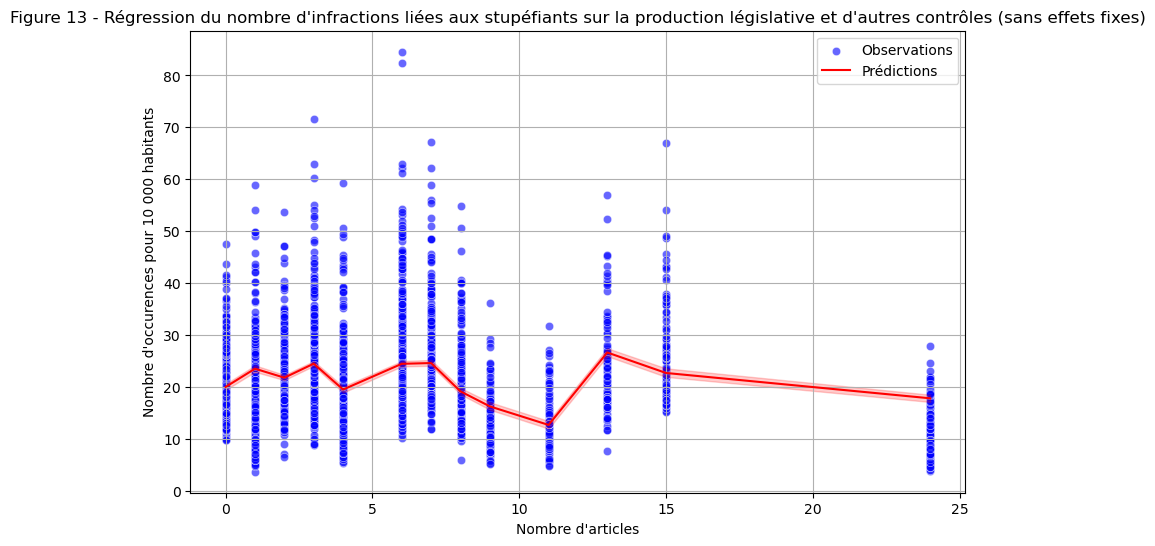

{'results':                           PanelOLS Estimation Summary                           
 Dep. Variable:         Taux (/10 000)   R-squared:                        0.3172
 Estimator:                   PanelOLS   R-squared (Between):              0.3130
 No. Observations:                2592   R-squared (Within):               0.3204
 Date:                Sun, Dec 29 2024   R-squared (Overall):              0.3172
 Time:                        19:49:39   Log-likelihood                   -9159.8
 Cov. Estimator:            Unadjusted                                           
                                         F-statistic:                      300.39
 Entities:                          96   P-value                           0.0000
 Avg Obs:                       27.000   Distribution:                  F(4,2587)
 Min Obs:                       27.000                                           
 Max Obs:                       27.000   F-statistic (robust):             300.39
     

In [29]:
# Régressions sans effets fixes stupéfiants
reg_stup_sans_effet = regression(mise_en_forme_reg('stupéfiant', 'Stupéfiants'), title="Figure 13 - Régression du nombre d'infractions liées aux stupéfiants sur la production législative et d'autres contrôles (sans effets fixes)")
reg_stup_sans_effet


Effets fixes par département:
                          estimated_effects
Nom Département                           
Ain                               2.923406
Aisne                            11.245732
Allier                           19.790727
Alpes-de-Haute-Provence          43.881489
Hautes-Alpes                     49.590111
...                                    ...
Essonne                         -27.931558
Hauts-de-Seine                 -134.828976
Seine-Saint-Denis               -90.697229
Val-de-Marne                    -81.767134
Val-d'Oise                      -21.576660

[2592 rows x 1 columns]


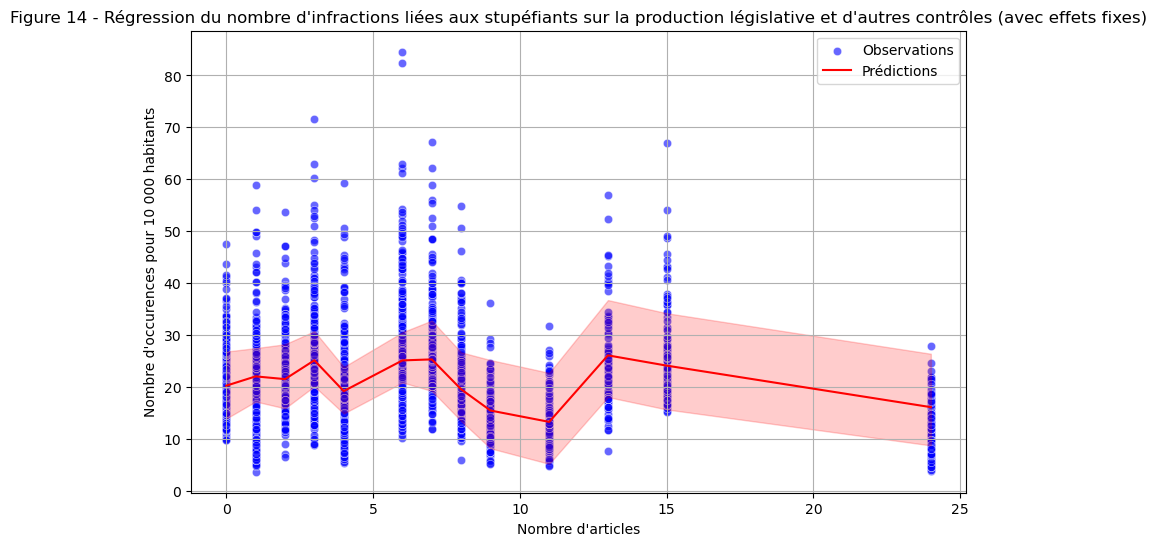

{'results':                           PanelOLS Estimation Summary                           
 Dep. Variable:         Taux (/10 000)   R-squared:                        0.4125
 Estimator:                   PanelOLS   R-squared (Between):             -40.217
 No. Observations:                2592   R-squared (Within):               0.4125
 Date:                Sun, Dec 29 2024   R-squared (Overall):             -17.346
 Time:                        19:32:47   Log-likelihood                   -8220.2
 Cov. Estimator:            Unadjusted                                           
                                         F-statistic:                      437.34
 Entities:                          96   P-value                           0.0000
 Avg Obs:                       27.000   Distribution:                  F(4,2492)
 Min Obs:                       27.000                                           
 Max Obs:                       27.000   F-statistic (robust):             437.34
     

In [24]:
# Régressions avec effets fixes stupéfiants
reg_stup_avec_effet = regression(mise_en_forme_reg('stupéfiant', 'Stupéfiants'), entity_effects=True, title="Figure 14 - Régression du nombre d'infractions liées aux stupéfiants sur la production législative et d'autres contrôles (avec effets fixes)")
reg_stup_avec_effet

In [25]:
# Test de Wald : Stupéfiants
Wald_test(reg_stup_avec_effet, reg_stup_sans_effet)

Wald Test Statistic: 1879.0446567238614
Degrees of Freedom: 95
P-value: 0.0


'Le modèle FEM est statistiquement significatif. Utilisez FEM.'

Ici c'est le 

### Essai d'étude avec décalage temporel<a class="anchor" id="partie54"></a>

Une possibilité pour mieux comprendre les relations entre taux de criminalité et production législative est d'introduire un décalage temporel. On peut en effet supposer qu'un certain temps est nécessaire avant que les lois ne fassent effets. Il est difficile d'imaginer quel est le décalage approprié, on en test donc plusieurs et on essaiera ensuite d'arbitrer selon le $R^2$ et les p-values des différentes régressions. On note que chaque décalage réduit notre nombre de période observée, on se limite donc à 10 décalages pour ne pas trop réduire notre nombre d'observations.

On utilise pour cela la fonction *regressions_lags* qui renvoie un tableau avec les différentes $R^2$ et p-values des régressions effectuées avec différentes décalages temporels.

In [26]:
# Code

## Conclusion et perspectives<a class="anchor" id="partie6"></a>